# 13. Pooling Cross Sections across Time: Simple Panel Data Methods

:::{important} Learning Objectives
:class: dropdown
By the end of this chapter, you should be able to:

**13.1** Explain the benefits and challenges of pooling independent cross sections across time.

**13.2** Use pooled cross-sectional data to analyze policy changes and quasi-experiments.

**13.3** Understand the structure and advantages of panel (longitudinal) data.

**13.4** Apply first-differencing and fixed effects methods to control for unobserved heterogeneity.

**13.5** Extend panel data methods to handle more than two time periods effectively.
:::

Welcome to Chapter 13, where we explore methods for combining data across time periods. This chapter introduces techniques for analyzing pooled cross-sectional data and panel data, which track the same units (individuals, firms, countries) over time. These methods allow us to control for unobserved heterogeneity and provide more credible causal estimates than pure cross-sectional analysis.

We'll learn how to leverage the time dimension in data to:
- Analyze policy changes using difference-in-differences
- Control for time-invariant unobserved factors using panel data
- Apply first-differencing and fixed effects estimators

Let's begin by setting up our environment with the necessary libraries.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge linearmodels -q

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import wooldridge as wool
from IPython.display import display
from linearmodels import FirstDifferenceOLS, PanelOLS

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 13.1 Pooling Independent Cross Sections across Time

When we have independent random samples from the same population at different points in time, we can **pool** these cross sections to increase sample size and statistical power. This approach is particularly useful when individual samples are small.

### Key Features of Pooled Cross-Sectional Data

1. **Independence**: Different individuals are sampled in each time period
2. **Time dummies**: We typically include year or time period indicators
3. **Increased precision**: Larger sample size leads to smaller standard errors
4. **Temporal variation**: Allows us to study changes over time

The basic pooled cross-sectional model is:

$$ y_{it} = \beta_0 + \delta_0 d2_t + \delta_1 d3_t + \ldots + \beta_1 x_{1,it} + \beta_2 x_{2,it} + \ldots + u_{it} $$

where:
- $i$ indexes individuals and $t$ indexes time periods
- $d2_t, d3_t, \ldots$ are time period dummy variables
- $\delta_0, \delta_1, \ldots$ capture time effects (shifts in intercept)

### Example 13.2: Effect of Education on Wages Across Time

We'll analyze how the return to education changed between 1978 and 1985 using the Current Population Survey (CPS) data.

In [3]:
# Load the CPS data for 1978 and 1985
cps78_85 = wool.data("cps78_85")

# Display basic information
print("Dataset shape:", cps78_85.shape)
print("\nVariable names:", cps78_85.columns.tolist())
print("\nSummary statistics:")
display(cps78_85.describe())

Dataset shape: (1084, 15)

Variable names: ['educ', 'south', 'nonwhite', 'female', 'married', 'exper', 'expersq', 'union', 'lwage', 'age', 'year', 'y85', 'y85fem', 'y85educ', 'y85union']

Summary statistics:


,educ,south,nonwhite,female,married,exper,expersq,union,lwage,age,year,y85,y85fem,y85educ,y85union
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000
mean,12.773985,0.294280,0.114391,0.416974,0.654059,18.276753,499.811808,0.243542,1.867301,36.539668,81.448339,0.492620,0.226015,6.413284,0.088561
std,2.705561,0.455929,0.318433,0.493286,0.475894,12.881195,599.324866,0.429418,0.542804,12.203919,3.501234,0.500176,0.418442,6.765212,0.284240
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.470000,18.000000,78.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,8.000000,64.000000,0.000000,1.470200,27.000000,78.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000,0.000000,1.000000,15.000000,225.000000,0.000000,1.832600,34.000000,78.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,1.000000,0.000000,1.000000,1.000000,28.000000,784.000000,0.000000,2.225100,46.000000,85.000000,1.000000,0.000000,12.000000,0.000000
max,18.000000,1.000000,1.000000,1.000000,1.000000,55.000000,3025.000000,1.000000,3.795500,64.000000,85.000000,1.000000,1.000000,18.000000,1.000000


In [4]:
# Check the distribution of observations across years
year_counts = cps78_85["year"].value_counts().sort_index()
print("Observations by year:")
print(year_counts)

Observations by year:
year
78    550
85    534
Name: count, dtype: int64


Now let's estimate a model with interactions to see how returns to education and the gender wage gap changed over time:

In [5]:
# Create year dummy (1985 = 1, 1978 = 0)
cps78_85["y85"] = (cps78_85["year"] == 85).astype(int)

# Estimate model with interaction terms
# The formula y85*(educ+female) expands to:
# y85 + educ + female + y85:educ + y85:female
model_interact = smf.ols(
    formula="lwage ~ y85*(educ+female) + exper + I((exper**2)/100) + union",
    data=cps78_85,
)
results_interact = model_interact.fit()

# Create formatted results table
results_table = pd.DataFrame(
    {
        "Coefficient": results_interact.params,
        "Std. Error": results_interact.bse,
        "t-statistic": results_interact.tvalues,
        "p-value": results_interact.pvalues,
    },
)
print("Pooled Regression with Interaction Terms")
print("=" * 70)
display(results_table.round(4))
print(f"\nR-squared: {results_interact.rsquared:.4f}")
print(f"Observations: {int(results_interact.nobs)}")

Pooled Regression with Interaction Terms


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.4589,0.0934,4.9111,0.0000
y85,0.1178,0.1238,0.9517,0.3415
educ,0.0747,0.0067,11.1917,0.0000
female,-0.3167,0.0366,-8.6482,0.0000
y85:educ,0.0185,0.0094,1.9735,0.0487
y85:female,0.0851,0.0513,1.6576,0.0977
exper,0.0296,0.0036,8.2932,0.0000
I((exper ** 2) / 100),-0.0399,0.0078,-5.1513,0.0000
union,0.2021,0.0303,6.6722,0.0000



R-squared: 0.4262
Observations: 1084


In [6]:
# Interpretation of key coefficients
print("INTERPRETATION OF KEY RESULTS:")
print("=" * 70)

# Base return to education in 1978
base_educ = results_interact.params["educ"]
print(f"\n1. Return to Education in 1978: {base_educ:.4f}")
print(f"   A one-year increase in education raises log(wage) by {base_educ:.4f}")
print(f"   Approximately {100 * base_educ:.2f}% increase in wages")

# Change in return to education from 1978 to 1985
change_educ = results_interact.params["y85:educ"]
print(f"\n2. Change in Return to Education (1985 vs 1978): {change_educ:.4f}")
if change_educ > 0:
    print(
        f"   The return to education INCREASED by {100 * change_educ:.2f} percentage points"
    )
else:
    print(
        f"   The return to education DECREASED by {-100 * change_educ:.2f} percentage points"
    )

# Total return to education in 1985
total_educ_1985 = base_educ + change_educ
print(f"\n3. Return to Education in 1985: {total_educ_1985:.4f}")
print(f"   This is {100 * total_educ_1985:.2f}% wage increase per year of education")

# Gender wage gap
female_coef = results_interact.params["female"]
print(f"\n4. Gender Wage Gap in 1978: {female_coef:.4f}")
print(f"   Women earned approximately {100 * female_coef:.2f}% less than men")

# Change in gender wage gap
if "y85:female" in results_interact.params:
    change_female = results_interact.params["y85:female"]
    print(f"\n5. Change in Gender Gap (1985 vs 1978): {change_female:.4f}")
    total_female_1985 = female_coef + change_female
    print(f"   Gender gap in 1985: {100 * total_female_1985:.2f}%")

INTERPRETATION OF KEY RESULTS:

1. Return to Education in 1978: 0.0747
   A one-year increase in education raises log(wage) by 0.0747
   Approximately 7.47% increase in wages

2. Change in Return to Education (1985 vs 1978): 0.0185
   The return to education INCREASED by 1.85 percentage points

3. Return to Education in 1985: 0.0932
   This is 9.32% wage increase per year of education

4. Gender Wage Gap in 1978: -0.3167
   Women earned approximately -31.67% less than men

5. Change in Gender Gap (1985 vs 1978): 0.0851
   Gender gap in 1985: -23.17%


## 13.2 Policy Analysis with Pooled Cross Sections

Pooled cross-sectional data is particularly powerful for evaluating policy changes using a **difference-in-differences** (DiD) approach. This method compares changes over time between a treatment group (affected by the policy) and a control group (unaffected).

### The Difference-in-Differences Framework

The DiD estimator isolates the causal effect of a policy by calculating:

$$ \text{DiD} = [\bar{y}_{\text{treatment, after}} - \bar{y}_{\text{treatment, before}}] - [\bar{y}_{\text{control, after}} - \bar{y}_{\text{control, before}}] $$

In regression form:

$$ y = \beta_0 + \delta_0 dT + \beta_1 dG + \delta_1 (dT \times dG) + \text{controls} + u $$

where:
- $dT$ = time dummy (1 for post-policy period)
- $dG$ = group dummy (1 for treatment group)
- $\delta_1$ = DiD estimator (the policy effect)

### Example 13.3: Effect of Incinerator Location on Housing Prices

We'll examine whether the location of a garbage incinerator affected nearby housing prices using data from Kiel and McClain (1995).

In [7]:
# Load housing price data from before and after incinerator announcement
kielmc = wool.data("kielmc")

print("Dataset Information:")
print(f"Total observations: {len(kielmc)}")
print(f"\nYears in dataset: {sorted(kielmc['year'].unique())}")
print("\nVariable nearinc: 1 if near incinerator, 0 otherwise")

Dataset Information:
Total observations: 321

Years in dataset: [np.int64(1978), np.int64(1981)]

Variable nearinc: 1 if near incinerator, 0 otherwise


In [8]:
# Examine the distribution of houses by year and proximity
cross_tab = pd.crosstab(
    kielmc["year"],
    kielmc["nearinc"],
    margins=True,
    margins_name="Total",
)
print("Houses by Year and Proximity to Incinerator:")
display(cross_tab)

Houses by Year and Proximity to Incinerator:


nearinc,0,1,Total
year,,,
1978,123,56,179
1981,102,40,142
Total,225,96,321


In [9]:
# Summary statistics by group
print("\nMean Housing Prices by Group:")
summary_stats = (
    kielmc.groupby(["year", "nearinc"])["rprice"].agg(["count", "mean", "std"]).round(2)
)
display(summary_stats)


Mean Housing Prices by Group:


count       mean       std
year nearinc                            
1978 0          123   82517.23  20831.10
     1           56   63692.86  42722.03
1981 0          102  101307.51  29741.12
     1           40   70619.24  34816.80

#### Separate Regressions for Each Year

First, let's run separate regressions for 1978 (before) and 1981 (after):

In [10]:
# Regression for 1978 (before incinerator announcement)
year_1978 = kielmc["year"] == 1978
model_1978 = smf.ols(formula="rprice ~ nearinc", data=kielmc, subset=year_1978)
results_1978 = model_1978.fit()

# Regression for 1981 (after incinerator announcement)
year_1981 = kielmc["year"] == 1981
model_1981 = smf.ols(formula="rprice ~ nearinc", data=kielmc, subset=year_1981)
results_1981 = model_1981.fit()

# Display results for 1978
print("REGRESSION RESULTS FOR 1978 (Before Incinerator)")
print("=" * 70)
table_1978 = pd.DataFrame(
    {
        "Coefficient": results_1978.params,
        "Std. Error": results_1978.bse,
        "t-statistic": results_1978.tvalues,
        "p-value": results_1978.pvalues,
    },
)
display(table_1978.round(4))
print(f"R-squared: {results_1978.rsquared:.4f}\n")

# Display results for 1981
print("REGRESSION RESULTS FOR 1981 (After Incinerator)")
print("=" * 70)
table_1981 = pd.DataFrame(
    {
        "Coefficient": results_1981.params,
        "Std. Error": results_1981.bse,
        "t-statistic": results_1981.tvalues,
        "p-value": results_1981.pvalues,
    },
)
display(table_1981.round(4))
print(f"R-squared: {results_1981.rsquared:.4f}")

REGRESSION RESULTS FOR 1978 (Before Incinerator)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,82517.2276,2653.790,31.0941,0.0000
nearinc,-18824.3705,4744.594,-3.9675,0.0001


R-squared: 0.0817

REGRESSION RESULTS FOR 1981 (After Incinerator)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,101307.5136,3093.0267,32.7535,0.0
nearinc,-30688.2738,5827.7088,-5.2659,0.0


R-squared: 0.1653


In [11]:
# Calculate simple difference-in-differences manually
print("\nMANUAL DIFFERENCE-IN-DIFFERENCES CALCULATION:")
print("=" * 70)

# Get coefficients
nearinc_1978 = results_1978.params["nearinc"]
nearinc_1981 = results_1981.params["nearinc"]

# Calculate DiD
did_estimate = nearinc_1981 - nearinc_1978

print(f"Effect in 1978 (before): ${nearinc_1978:,.2f}")
print(f"Effect in 1981 (after):  ${nearinc_1981:,.2f}")
print(f"\nDiD Estimate: ${did_estimate:,.2f}")
print(
    f"Interpretation: The incinerator caused a ${abs(did_estimate):,.2f} {'decrease' if did_estimate < 0 else 'increase'} in nearby housing prices",
)


MANUAL DIFFERENCE-IN-DIFFERENCES CALCULATION:
Effect in 1978 (before): $-18,824.37
Effect in 1981 (after):  $-30,688.27

DiD Estimate: $-11,863.90
Interpretation: The incinerator caused a $11,863.90 decrease in nearby housing prices


#### Joint Regression with Interaction Term

Now let's estimate the DiD using a single pooled regression with an interaction term:

In [12]:
# Pooled regression with interaction term
# This automatically computes the DiD estimator
model_joint = smf.ols(formula="rprice ~ nearinc * C(year)", data=kielmc)
results_joint = model_joint.fit()

print("\nPOOLED REGRESSION WITH INTERACTION (Difference-in-Differences)")
print("=" * 70)
table_joint = pd.DataFrame(
    {
        "Coefficient": results_joint.params,
        "Std. Error": results_joint.bse,
        "t-statistic": results_joint.tvalues,
        "p-value": results_joint.pvalues,
    },
)
display(table_joint.round(4))
print(f"\nR-squared: {results_joint.rsquared:.4f}")
print(f"Observations: {int(results_joint.nobs)}")


POOLED REGRESSION WITH INTERACTION (Difference-in-Differences)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,82517.2276,2726.9101,30.2603,0.0000
C(year)[T.1981],18790.2860,4050.0650,4.6395,0.0000
nearinc,-18824.3705,4875.3221,-3.8612,0.0001
nearinc:C(year)[T.1981],-11863.9033,7456.6462,-1.5911,0.1126



R-squared: 0.1739
Observations: 321


In [13]:
# Interpretation of the DiD estimate from pooled regression
print("\nINTERPRETATION OF POOLED REGRESSION:")
print("=" * 70)

# The interaction term is the DiD estimator
interaction_coef = results_joint.params["nearinc:C(year)[T.1981]"]
interaction_se = results_joint.bse["nearinc:C(year)[T.1981]"]
interaction_t = results_joint.tvalues["nearinc:C(year)[T.1981]"]
interaction_p = results_joint.pvalues["nearinc:C(year)[T.1981]"]

print(f"\nDiD Estimate (interaction term): ${interaction_coef:,.2f}")
print(f"Standard Error: ${interaction_se:,.2f}")
print(f"t-statistic: {interaction_t:.4f}")
print(f"p-value: {interaction_p:.4f}")

if interaction_p < 0.05:
    print(
        "\n✓ The effect is statistically significant at the 5% level",
    )
    print(
        f"  The incinerator caused a ${abs(interaction_coef):,.2f} {'decrease' if interaction_coef < 0 else 'increase'} in nearby housing prices",
    )
else:
    print(
        "\n✗ The effect is NOT statistically significant at the 5% level",
    )
    print("  We cannot conclude the incinerator had a causal effect on prices")


INTERPRETATION OF POOLED REGRESSION:

DiD Estimate (interaction term): $-11,863.90
Standard Error: $7,456.65
t-statistic: -1.5911
p-value: 0.1126

✗ The effect is NOT statistically significant at the 5% level
  We cannot conclude the incinerator had a causal effect on prices


## 13.3 Two-Period Panel Data Analysis

**Panel data** (also called longitudinal data) tracks the same units over time. Unlike pooled cross sections, panel data follows the same individuals, firms, or entities across multiple periods.

### Advantages of Panel Data

1. **Control for unobserved heterogeneity**: Eliminate time-invariant confounders
2. **More efficient estimation**: Uses within-unit variation
3. **Stronger causal inference**: Differences away stable characteristics

### The Two-Period Model

For two periods, the panel data model is:

$$ y_{it} = \beta_0 + \delta_0 d2_t + \beta_1 x_{1,it} + a_i + u_{it}, \quad t = 1, 2 $$

where:
- $a_i$ = individual-specific unobserved effect (time-invariant)
- $d2_t$ = time dummy for period 2
- $u_{it}$ = idiosyncratic error (varies over $i$ and $t$)

**The key challenge**: $a_i$ may be correlated with the explanatory variables, causing omitted variable bias in regular OLS.

**The solution**: First-differencing eliminates $a_i$ by taking differences between the two periods:

$$ \Delta y_i = \delta_0 + \beta_1 \Delta x_{1,i} + \Delta u_i $$

where $\Delta y_i = y_{i2} - y_{i1}$, $\Delta x_{1,i} = x_{1,i2} - x_{1,i1}$, and $\Delta u_i = u_{i2} - u_{i1}$.

Notice that $a_i$ has disappeared! This is the power of panel data.

### Example: Crime Rates and Law Enforcement (Conceptual)

Suppose we want to estimate the effect of police presence ($\text{police}_it$) on crime rates ($\text{crime}_it$) using city-level data for two years.

The naive pooled OLS model might give biased estimates because cities with inherently higher crime (high $a_i$) might also have more police, creating a spurious positive correlation.

First-differencing solves this:

$$ \Delta \text{crime}_i = \beta_0 + \beta_1 \Delta \text{police}_i + \Delta u_i $$

Now $\beta_1$ identifies the causal effect of changes in police on changes in crime, holding constant all time-invariant city characteristics (poverty rates, culture, geography, etc.).

## 13.4 Policy Analysis with Two-Period Panel Data

Panel data is particularly powerful for policy evaluation. We can use the same difference-in-differences logic, but now with repeated observations on the same units.

### Panel Data DiD Model

$$ y_{it} = \beta_0 + \delta_0 d2_t + \beta_1 dG_i + \delta_1 (d2_t \times dG_i) + a_i + u_{it} $$

Taking first differences:

$$ \Delta y_i = \delta_0 + \delta_1 dG_i + \Delta u_i $$

The parameter $\delta_1$ is the DiD estimator, measuring the policy effect on the treatment group relative to the control group.

### Key Assumption: Parallel Trends

The DiD approach requires that, in the absence of treatment, both groups would have followed parallel trends. This is untestable but can be assessed with:
- Pre-treatment trends (if more periods are available)
- Placebo tests
- Economic reasoning

## 13.5 Differencing with More Than Two Time Periods

When we have panel data with $T > 2$ time periods, we can use **first-differencing** or **fixed effects** estimation to control for unobserved heterogeneity.

### First-Differencing (FD) Estimator

For each unit $i$, take first differences across consecutive time periods:

$$ \Delta y_{it} = y_{it} - y_{i,t-1} = \beta_1 \Delta x_{1,it} + \ldots + \Delta u_{it} $$

where $\Delta u_{it} = u_{it} - u_{i,t-1}$.

### Key Properties of FD

1. **Eliminates** the unobserved effect $a_i$
2. **Requires** strict exogeneity: $E(u_{it}|x_{i1}, \ldots, x_{iT}, a_i) = 0$ for all $t$
3. **Loses** one time period per unit (first period has no prior period to difference from)
4. **Creates** serial correlation in $\Delta u_{it}$ even if $u_{it}$ is not serially correlated

### Example 13.9: Effect of Law Enforcement on Crime Rates

We'll use county-level crime data from North Carolina (1981-1987) to estimate the effect of various criminal justice variables on crime rates.

In [14]:
# Load crime panel data
crime4 = wool.data("crime4")

print("Dataset Information:")
print(f"Total observations: {len(crime4)}")
print(f"Number of counties: {crime4['county'].nunique()}")
print(f"Years: {sorted(crime4['year'].unique())}")
print(f"Time periods: {len(crime4['year'].unique())}")

# Display first few observations
print("\nFirst few observations:")
display(crime4.head(10))

Dataset Information:
Total observations: 630
Number of counties: 90
Years: [np.int64(81), np.int64(82), np.int64(83), np.int64(84), np.int64(85), np.int64(86), np.int64(87)]
Time periods: 7

First few observations:


,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,...,lpctymle,lpctmin,clcrmrte,clprbarr,clprbcon,clprbpri,clavgsen,clpolpc,cltaxpc,clmix
0,1,81,0.039885,0.289696,0.402062,0.472222,5.61,0.001787,2.307159,25.697630,...,-2.433870,3.006608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,82,0.038345,0.338111,0.433005,0.506993,5.59,0.001767,2.330254,24.874252,...,-2.449038,3.006608,-0.039376,0.154542,0.074143,0.071048,-0.003571,-0.011364,-0.032565,0.030857
2,1,83,0.030305,0.330449,0.525703,0.479705,5.80,0.001836,2.341801,26.451443,...,-2.464036,3.006608,-0.235316,-0.022922,0.193987,-0.055326,0.036879,0.038413,0.061477,-0.244732
3,1,84,0.034726,0.362525,0.604706,0.520104,6.89,0.001886,2.346420,26.842348,...,-2.478925,3.006608,0.136180,0.092641,0.140006,0.080857,0.172213,0.026930,0.014670,-0.027331
4,1,85,0.036573,0.325395,0.578723,0.497059,6.55,0.001924,2.364896,28.140337,...,-2.497306,3.006608,0.051825,-0.108054,-0.043918,-0.045320,-0.050606,0.020199,0.047223,0.172125
5,1,86,0.034752,0.326062,0.512324,0.439863,6.90,0.001895,2.385681,29.740980,...,-2.524721,3.006608,-0.051062,0.002048,-0.121867,-0.122245,0.052056,-0.015258,0.055322,0.042765
6,1,87,0.035604,0.298270,0.527596,0.436170,6.71,0.001828,2.422633,30.993681,...,-2.552702,3.006608,0.024198,-0.089089,0.029374,-0.008431,-0.027923,-0.036189,0.041257,-0.193899
7,3,81,0.016392,0.202899,0.869048,0.465753,8.45,0.000594,0.976834,14.560878,...,-2.441794,2.068926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3,82,0.019065,0.162218,0.772152,0.377049,5.71,0.000705,0.992278,35.640728,...,-2.447933,2.068926,0.151060,-0.223767,-0.118217,-0.211280,-0.391948,0.170985,0.895151,-0.170775
9,3,83,0.015149,0.181586,1.028170,0.438356,8.69,0.000659,1.003861,19.261877,...,-2.454076,2.068926,-0.229912,0.112788,0.286354,0.150656,0.419954,-0.067522,-0.615361,0.231241


In [15]:
# Summary statistics for key variables
key_vars = ["crmrte", "prbarr", "prbconv", "prbpris", "avgsen", "polpc"]
print("\nSummary Statistics for Key Variables:")
display(crime4[key_vars].describe().round(4))


Summary Statistics for Key Variables:


,crmrte,prbarr,prbconv,prbpris,avgsen,polpc
count,630.0000,630.0000,630.0000,630.0000,630.0000,630.0000
mean,0.0316,0.3074,0.6886,0.4255,8.9545,0.0019
std,0.0181,0.1712,1.6903,0.0872,2.6581,0.0027
min,0.0018,0.0588,0.0684,0.1489,4.2200,0.0005
25%,0.0184,0.2179,0.3477,0.3744,7.1600,0.0012
50%,0.0284,0.2782,0.4744,0.4286,8.4950,0.0015
75%,0.0384,0.3525,0.6356,0.4832,10.1975,0.0018
max,0.1638,2.7500,37.0000,0.6786,25.8300,0.0356


In [16]:
# Set the panel structure (county and year as index)
crime4_panel = crime4.set_index(["county", "year"], drop=False)

# Create year dummies manually
for year in [83, 84, 85, 86, 87]:
    crime4_panel[f"d{year}"] = (crime4_panel["year"] == year).astype(int)

print("Panel data structure set up successfully")
print(f"Panel index levels: {crime4_panel.index.names}")

Panel data structure set up successfully
Panel index levels: ['county', 'year']


In [17]:
# Estimate first-difference model using linearmodels
# This package provides specialized panel data estimators

fd_model = FirstDifferenceOLS.from_formula(
    formula="np.log(crmrte) ~ year + d83 + d84 + d85 + d86 + d87 + "
    "np.log(prbarr) + np.log(prbconv) + np.log(prbpris) + "
    "np.log(avgsen) + np.log(polpc)",
    data=crime4_panel,
)

fd_results = fd_model.fit()

print("FIRST-DIFFERENCE ESTIMATION RESULTS")
print("=" * 70)
print(fd_results)

FIRST-DIFFERENCE ESTIMATION RESULTS
                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:         np.log(crmrte)   R-squared:                        0.4326
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.6003
No. Observations:                 540   R-squared (Within):               0.4281
Date:                Sun, Oct 19 2025   R-squared (Overall):              0.6000
Time:                        17:53:12   Log-likelihood                    248.48
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      36.661
Entities:                          90   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(11,529)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):            

In [18]:
# Interpretation of results
print("\nINTERPRETATION OF FIRST-DIFFERENCE ESTIMATES:")
print("=" * 70)

# Extract coefficients
params = fd_results.params

print("\nElasticity Interpretations (all variables in logs):")
print(
    f"\n1. log(prbarr) - Probability of Arrest: {params['np.log(prbarr)']:.4f}",
)
print(
    "   A 1% increase in arrest probability reduces crime by "
    f"{abs(params['np.log(prbarr)']):.2f}%"
)

print(
    f"\n2. log(prbconv) - Probability of Conviction: {params['np.log(prbconv)']:.4f}",
)
print(
    "   A 1% increase in conviction probability affects crime by "
    f"{params['np.log(prbconv)']:.2f}%"
)

print(
    f"\n3. log(prbpris) - Probability of Prison: {params['np.log(prbpris)']:.4f}",
)
print(
    "   A 1% increase in prison probability affects crime by "
    f"{params['np.log(prbpris)']:.2f}%"
)

print(f"\n4. log(avgsen) - Average Sentence: {params['np.log(avgsen)']:.4f}")
print(
    "   A 1% increase in sentence length affects crime by "
    f"{params['np.log(avgsen)']:.2f}%"
)

print(f"\n5. log(polpc) - Police Per Capita: {params['np.log(polpc)']:.4f}")
print(
    "   A 1% increase in police per capita affects crime by "
    f"{params['np.log(polpc)']:.2f}%"
)

print("\n" + "=" * 70)
print("Note: First-differencing controls for all time-invariant county")
print("characteristics (e.g., poverty, culture, geography) that might")
print("be correlated with both crime and law enforcement variables.")


INTERPRETATION OF FIRST-DIFFERENCE ESTIMATES:

Elasticity Interpretations (all variables in logs):

1. log(prbarr) - Probability of Arrest: -0.3275
   A 1% increase in arrest probability reduces crime by 0.33%

2. log(prbconv) - Probability of Conviction: -0.2381
   A 1% increase in conviction probability affects crime by -0.24%

3. log(prbpris) - Probability of Prison: -0.1650
   A 1% increase in prison probability affects crime by -0.17%

4. log(avgsen) - Average Sentence: -0.0218
   A 1% increase in sentence length affects crime by -0.02%

5. log(polpc) - Police Per Capita: 0.3984
   A 1% increase in police per capita affects crime by 0.40%

Note: First-differencing controls for all time-invariant county
characteristics (e.g., poverty, culture, geography) that might
be correlated with both crime and law enforcement variables.


### Alternative: Fixed Effects (Within) Estimator

An alternative to first-differencing is the **fixed effects** or **within** estimator. Instead of differencing, it de-means each variable:

$$ \ddot{y}_{it} = y_{it} - \bar{y}_i = \beta_1 \ddot{x}_{1,it} + \ldots + \ddot{u}_{it} $$

where $\bar{y}_i = T^{-1} \sum_{t=1}^T y_{it}$ is the time average for unit $i$.

**FD vs FE**: Both eliminate $a_i$, but they differ when $T > 2$:
- FE is more efficient when errors are serially uncorrelated
- FD is more robust to certain forms of serial correlation
- With $T = 2$, FD and FE are numerically equivalent

In [19]:
# Compare FD and FE estimators
fe_model = PanelOLS.from_formula(
    formula="np.log(crmrte) ~ year + d83 + d84 + d85 + d86 + d87 + "
    "np.log(prbarr) + np.log(prbconv) + np.log(prbpris) + "
    "np.log(avgsen) + np.log(polpc) + EntityEffects",
    data=crime4_panel,
)

fe_results = fe_model.fit()

print("FIXED EFFECTS ESTIMATION RESULTS")
print("=" * 70)
print(fe_results)

FIXED EFFECTS ESTIMATION RESULTS
                          PanelOLS Estimation Summary                           
Dep. Variable:         np.log(crmrte)   R-squared:                        0.4342
Estimator:                   PanelOLS   R-squared (Between):              0.4696
No. Observations:                 630   R-squared (Within):               0.4342
Date:                Sun, Oct 19 2025   R-squared (Overall):              0.4695
Time:                        17:53:12   Log-likelihood                    405.58
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      36.911
Entities:                          90   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(11,529)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             36

In [20]:
# Compare FD and FE coefficients
comparison = pd.DataFrame(
    {
        "First-Difference": fd_results.params,
        "Fixed Effects": fe_results.params,
        "Difference": fd_results.params - fe_results.params,
    },
)

print("\nCOMPARISON OF FD AND FE ESTIMATES:")
print("=" * 70)
display(comparison.round(4))

print("\nNote: With many time periods (T=7 here), FD and FE can give")
print("different estimates. The choice depends on the structure of")
print("serial correlation in the errors.")


COMPARISON OF FD AND FE ESTIMATES:


,First-Difference,Fixed Effects,Difference
year,0.0077,0.0126,-0.0049
d83,-0.0999,-0.1044,0.0046
d84,-0.1478,-0.1555,0.0077
d85,-0.1524,-0.1623,0.0099
d86,-0.1249,-0.1447,0.0198
d87,-0.0841,-0.1160,0.0319
np.log(prbarr),-0.3275,-0.3598,0.0323
np.log(prbconv),-0.2381,-0.2859,0.0478
np.log(prbpris),-0.1650,-0.1828,0.0177
np.log(avgsen),-0.0218,-0.0045,-0.0173



Note: With many time periods (T=7 here), FD and FE can give
different estimates. The choice depends on the structure of
serial correlation in the errors.


## Summary

In this chapter, we explored methods for analyzing data across time:

1. **Pooled Cross Sections**: Combine independent samples from different periods
   - Increases sample size and precision
   - Can study changes over time with interaction terms

2. **Difference-in-Differences**: Evaluate policy effects using treatment and control groups
   - Identifies causal effects under parallel trends assumption
   - Robust to time-invariant confounders

3. **Two-Period Panel Data**: Follow same units over two periods
   - First-differencing eliminates time-invariant unobserved effects
   - Provides stronger causal inference than cross-sectional methods

4. **Multi-Period Panel Data**: Extend to T > 2 periods
   - First-differencing or fixed effects to control for heterogeneity
   - Choice depends on serial correlation structure

**Key Insight**: The time dimension in data provides powerful tools for causal inference by allowing us to control for unobserved heterogeneity that would otherwise bias our estimates.

**Next Steps**: In Chapter 14, we'll explore more advanced panel data methods, including random effects models and the correlated random effects approach.

/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77785/8324465.py:65: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


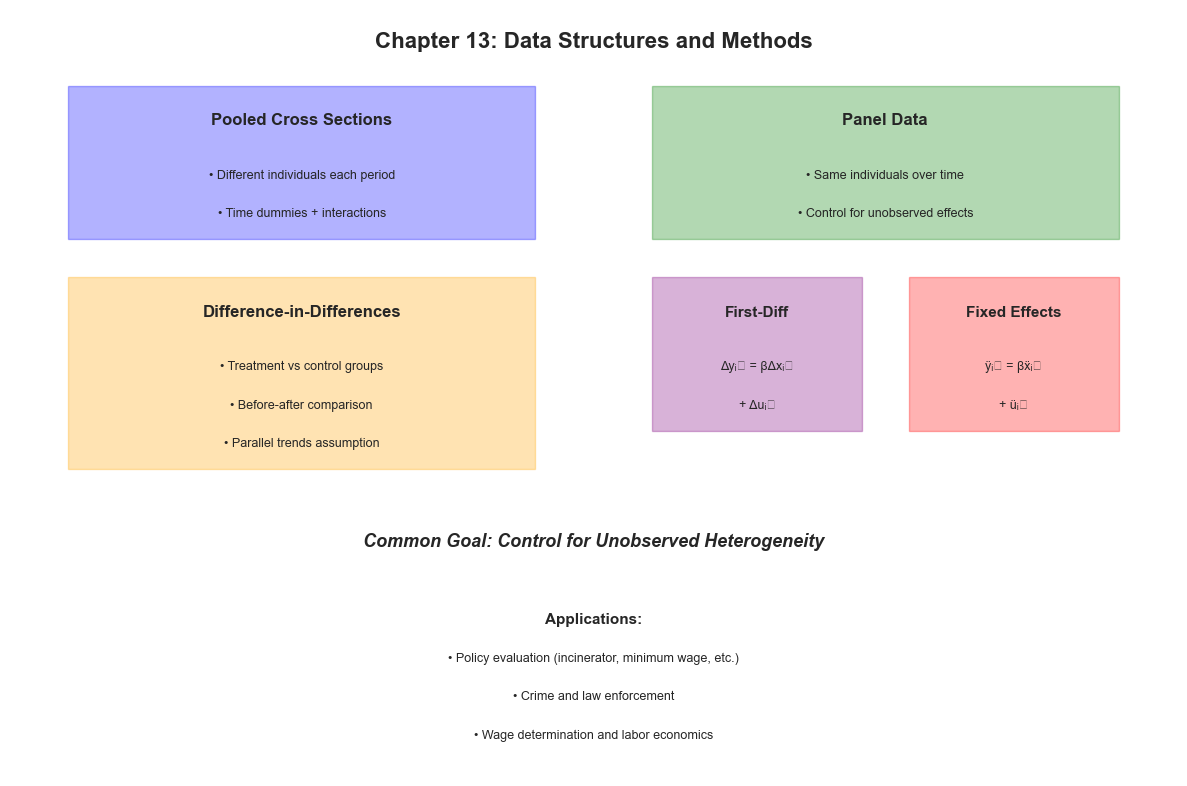

In [21]:
# Visual summary of methods covered
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 8))
ax.axis("off")

# Title
ax.text(
    0.5,
    0.95,
    "Chapter 13: Data Structures and Methods",
    ha="center",
    fontsize=16,
    fontweight="bold",
)

# Pooled Cross Sections
ax.add_patch(
    mpatches.Rectangle((0.05, 0.70), 0.40, 0.20, fill=True, alpha=0.3, color="blue")
)
ax.text(
    0.25, 0.85, "Pooled Cross Sections", ha="center", fontsize=12, fontweight="bold"
)
ax.text(0.25, 0.78, "• Different individuals each period", ha="center", fontsize=9)
ax.text(0.25, 0.73, "• Time dummies + interactions", ha="center", fontsize=9)

# Panel Data
ax.add_patch(
    mpatches.Rectangle((0.55, 0.70), 0.40, 0.20, fill=True, alpha=0.3, color="green")
)
ax.text(0.75, 0.85, "Panel Data", ha="center", fontsize=12, fontweight="bold")
ax.text(0.75, 0.78, "• Same individuals over time", ha="center", fontsize=9)
ax.text(0.75, 0.73, "• Control for unobserved effects", ha="center", fontsize=9)

# DiD
ax.add_patch(
    mpatches.Rectangle((0.05, 0.40), 0.40, 0.25, fill=True, alpha=0.3, color="orange")
)
ax.text(
    0.25, 0.60, "Difference-in-Differences", ha="center", fontsize=12, fontweight="bold"
)
ax.text(0.25, 0.53, "• Treatment vs control groups", ha="center", fontsize=9)
ax.text(0.25, 0.48, "• Before-after comparison", ha="center", fontsize=9)
ax.text(0.25, 0.43, "• Parallel trends assumption", ha="center", fontsize=9)

# FD
ax.add_patch(
    mpatches.Rectangle((0.55, 0.45), 0.18, 0.20, fill=True, alpha=0.3, color="purple")
)
ax.text(0.64, 0.60, "First-Diff", ha="center", fontsize=11, fontweight="bold")
ax.text(0.64, 0.53, "Δyᵢₜ = βΔxᵢₜ", ha="center", fontsize=9)
ax.text(0.64, 0.48, "+ Δuᵢₜ", ha="center", fontsize=9)

# FE
ax.add_patch(
    mpatches.Rectangle((0.77, 0.45), 0.18, 0.20, fill=True, alpha=0.3, color="red")
)
ax.text(0.86, 0.60, "Fixed Effects", ha="center", fontsize=11, fontweight="bold")
ax.text(0.86, 0.53, "ÿᵢₜ = βẍᵢₜ", ha="center", fontsize=9)
ax.text(0.86, 0.48, "+ üᵢₜ", ha="center", fontsize=9)

# Key advantage
ax.text(
    0.5,
    0.30,
    "Common Goal: Control for Unobserved Heterogeneity",
    ha="center",
    fontsize=13,
    fontweight="bold",
    style="italic",
)

# Applications
ax.text(0.5, 0.20, "Applications:", ha="center", fontsize=11, fontweight="bold")
ax.text(
    0.5,
    0.15,
    "• Policy evaluation (incinerator, minimum wage, etc.)",
    ha="center",
    fontsize=9,
)
ax.text(0.5, 0.10, "• Crime and law enforcement", ha="center", fontsize=9)
ax.text(0.5, 0.05, "• Wage determination and labor economics", ha="center", fontsize=9)

plt.tight_layout()
plt.show()